In [6]:
import shutil
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization, LeakyReLU,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

def create_test_split(data_paths, output_test_dir, positive_ratio=0.5):
    """
    Hàm này tự động chia dữ liệu thành tập kiểm tra với Positive và Negative.

    :param data_paths: Danh sách các đường dẫn tới thư mục chứa dữ liệu gốc.
    :param output_test_dir: Đường dẫn tới thư mục lưu trữ tập kiểm tra.
    :param positive_ratio: Tỷ lệ hình ảnh Positive trong tập kiểm tra (giá trị từ 0 đến 1).
    """
    # Tạo thư mục đầu ra nếu chưa tồn tại
    os.makedirs(output_test_dir, exist_ok=True)
    positive_dir = os.path.join(output_test_dir, "Positive")
    negative_dir = os.path.join(output_test_dir, "Negative")

    os.makedirs(positive_dir, exist_ok=True)
    os.makedirs(negative_dir, exist_ok=True)

    all_images = []

    # Lặp qua tất cả các đường dẫn chứa dữ liệu
    for path in data_paths:
        for file in os.listdir(path):
            if file.endswith('.BMP'):
                all_images.append(os.path.join(path, file))  # Thêm đường dẫn đầy đủ của hình ảnh

    # Chia hình ảnh thành Positive và Negative
    num_positive = int(len(all_images) * positive_ratio)
    positive_images = all_images[:num_positive]  # Chọn một phần cho Positive
    negative_images = all_images[num_positive:]  # Phần còn lại cho Negative

    # Di chuyển hình ảnh vào các thư mục tương ứng
    for img in positive_images:
        shutil.copy(img, os.path.join(positive_dir, os.path.basename(img)))

    for img in negative_images:
        shutil.copy(img, os.path.join(negative_dir, os.path.basename(img)))

# Ví dụ sử dụng hàm
data_paths = [
    "Data\\SOCOFing\\Real",
    "Data\\SOCOFing\\Altered\\Altered-Easy",
]

output_test_dir = "Data\\SOCOFing\\Test"  # Đường dẫn tới thư mục lưu trữ tập kiểm tra

create_test_split(data_paths, output_test_dir, positive_ratio=0.5)

In [8]:
img_width,img_height = 96,96

def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), input_shape=(img_height, img_width, 1)),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3)),
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3)),
        MaxPooling2D((2, 2)),
        
        Conv2D(256, (3, 3)),
        MaxPooling2D((2, 2)),
        
        GlobalAveragePooling2D(),
        
        Dense(512, activation='relu'),
        Dropout(0.5),
        
        Dense(256, activation='relu'),
        Dropout(0.5),
        
        Dense(600, activation='softmax')  # Lớp đầu ra cho phân loại
    ])
    return model
model = create_model()

In [9]:
model.load_weights('fingerprint_model_weights.weights.h5')

In [10]:
from sklearn.metrics.pairwise import cosine_similarity
def preprocess_images(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_width, img_height))
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=-1)  # Thêm chiều cho ảnh
    return img

def evaluate_threshold(test_data_path, model, features):
    positive_similarities = []
    negative_similarities = []

    # Xử lý các hình ảnh Positive
    positive_dir = os.path.join(test_data_path, "Positive")
    for file in os.listdir(positive_dir):
        if file.endswith(".BMP"):
            img_path = os.path.join(positive_dir, file)
            input_image = preprocess_images(img_path)
            input_image = np.expand_dims(input_image, axis=0)

            # Trích xuất đặc trưng
            input_feature = model.predict(input_image).flatten()
            similarity = cosine_similarity([input_feature], features)
            positive_similarities.append(np.max(similarity))

    # Xử lý các hình ảnh Negative
    negative_dir = os.path.join(test_data_path, "Negative")
    for file in os.listdir(negative_dir):
        if file.endswith(".BMP"):
            img_path = os.path.join(negative_dir, file)
            input_image = preprocess_images(img_path)
            input_image = np.expand_dims(input_image, axis=0)

            # Trích xuất đặc trưng
            input_feature = model.predict(input_image).flatten()
            similarity = cosine_similarity([input_feature], features)
            negative_similarities.append(np.max(similarity))

    return positive_similarities, negative_similarities

# Ví dụ sử dụng hàm
test_data_path = "Data/SOCOFing/Test"
features = np.load('fingerprint_features.npy')  # Tải đặc trưng đã lưu
positive_similarities, negative_similarities = evaluate_threshold(test_data_path, model, features)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━

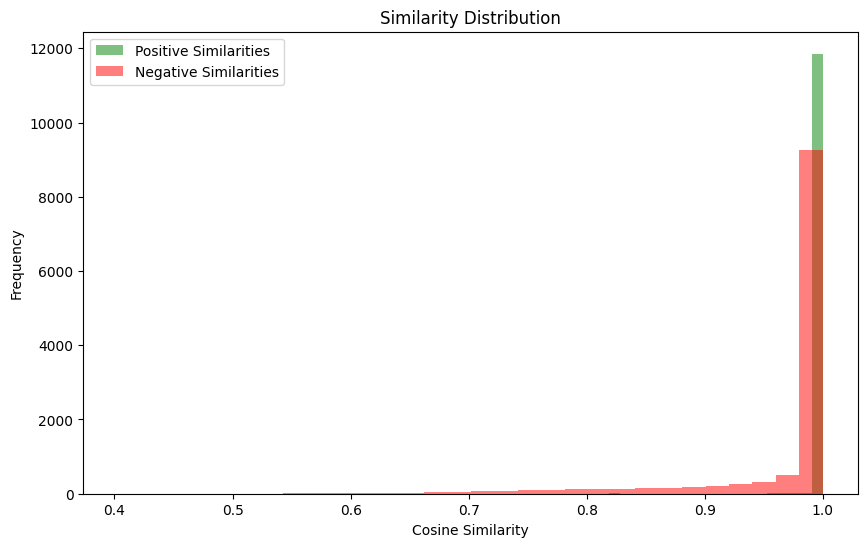

In [11]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ phân phối độ tương đồng
plt.figure(figsize=(10, 6))
plt.hist(positive_similarities, bins=30, alpha=0.5, label='Positive Similarities', color='g')
plt.hist(negative_similarities, bins=30, alpha=0.5, label='Negative Similarities', color='r')
plt.title('Similarity Distribution')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [12]:
def find_optimal_threshold(positive_similarities, negative_similarities):
    # Tính ngưỡng trung bình
    mean_positive = np.mean(positive_similarities)
    mean_negative = np.mean(negative_similarities)

    # Ngưỡng tối ưu có thể là giá trị trung bình giữa hai giá trị này
    optimal_threshold = (mean_positive + mean_negative) / 2
    return optimal_threshold

# Tìm ngưỡng tối ưu
optimal_threshold = find_optimal_threshold(positive_similarities, negative_similarities)
print(f'Optimal threshold: {optimal_threshold:.2f}')

Optimal threshold: 0.98
